In [1]:
using QuantumCollocation
using NamedTrajectories
using TrajectoryIndexingUtils
using Flux
using ReinforcementLearning
using IntervalSets
using LinearAlgebra
using Base
using Distributions
using Statistics
using Printf
using Reexport
using Revise
using DomainSets
using CairoMakie

includet("PPO.jl")
includet("AIRL.jl")
includet("GateEnvs.jl")

In [2]:
RZ_traj = load_traj("RZ_pretrained.jld2")

const Units = 1e9
const MHz = 1e6 / Units
const GHz = 1e9 / Units
const ns = 1e-9 * Units
const μs = 1e-6 * Units
;


# Operators
const Paulis = Dict(
    "I" => Matrix{ComplexF64}([1 0; 0 1]),
    "X" => Matrix{ComplexF64}([0 1; 1 0]),
    "Y" => Matrix{ComplexF64}([0 im; -im 0]),
    "Z" => Matrix{ComplexF64}([1 0; 0 -1]),
)

rz_op(theta) = exp(-im/2 * theta[1] * Paulis["Z"]);

RZ = Gate(1,rz_op)

H_drives = [
     Paulis["X"],Paulis["Y"]
]
system = QuantumSystem(H_drives);
t_f = 10* ns
n_steps = 51
times = range(0, t_f, n_steps)  # Alternative: collect(0:Δt:t_f)
n_controls=1
n_qubits=1;
Δt = times[2] - times[1]

N = 11
;

In [3]:
Pretraining_Env = GatePretrainingEnv(
                                    system,
                                    n_steps,
                                    RZ,
                                    Δt,
                                    N,
                                    RZ_traj;
                                    dda_bound=1.5
                                    )
pretraining_𝒫 = ActorCriticPolicy(Pretraining_Env;)
pretraining_bc_𝒫 = ActorCriticPolicy(Pretraining_Env;)
load_policy(pretraining_𝒫,"initial_policy.jld2")
load_policy(pretraining_bc_𝒫,"bc_policy.jld2")

ActorCriticPolicy(Chain(Dense(14 => 128, tanh), Dense(128 => 128, tanh)), Dense(128 => 2, tanh), Dense(128 => 1, log_std_clip), Chain(Dense(14 => 128, tanh), Dense(128 => 128, tanh), Dense(128 => 1)))

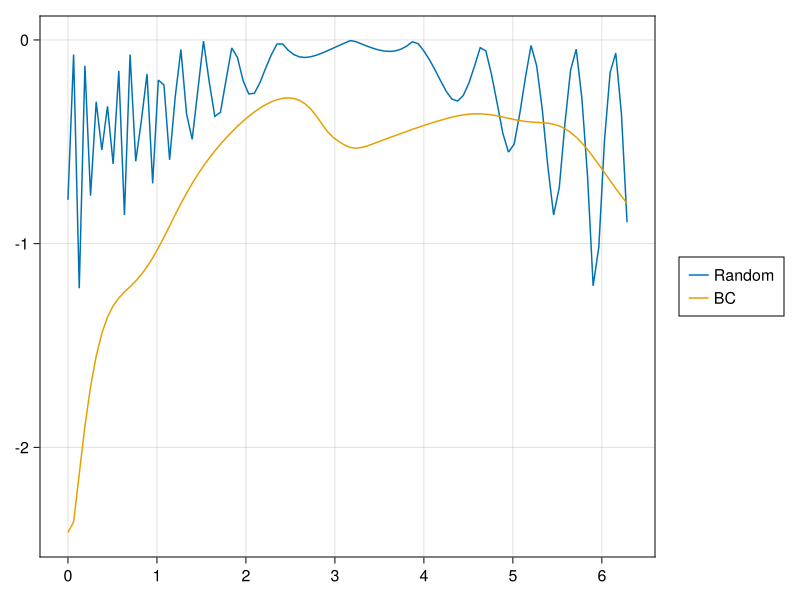

In [4]:
fig = Figure()
infid_data = policy_sample(Pretraining_Env,pretraining_𝒫,100)
infid_data1 = policy_sample(Pretraining_Env,pretraining_bc_𝒫,100)
ax = Axis(fig[1, 1])
l = lines!(ax,range(0,2π,length(infid_data)),log10.(infid_data))
l1 = lines!(ax,range(0,2π,length(infid_data1)),log10.(infid_data1))
Legend(fig[1, 2],
    [l, l1],
    ["Random", "BC"])
fig

In [5]:
PPO_pretraining_𝒫,score_history = PPO(Pretraining_Env;η=3f-4,iterations=50,n_steps=1,trajectory_batch_size=40,vf_ratio=5f-1,norm_adv = true,ϵ= 2f-1,ent_ratio=1f-3,KL_targ=5f-2,initial_policy=pretraining_𝒫,clip_grad_tresh=5f-1,use_log_rewards=false)

Iterations 1 Complete
Updates 22
Avg Score: -53.23182
Total Steps: 1920
Total Trajectories: 40
Final KL: 0.20893
Mean Policy Loss: -0.04020
Mean Value Loss: 2206.08179
Mean Entropy: 2.55067
Mean ADV: -23.60620
Mean Clip Ratio: 0.19957
-------------------------
Iterations 2 Complete
Updates 262
Avg Score: -56.22240
Total Steps: 1920
Total Trajectories: 40
Final KL: 0.03942
Mean Policy Loss: 0.00302
Mean Value Loss: 1366.81018
Mean Entropy: 2.05880
Mean ADV: -25.05480
Mean Clip Ratio: 0.13866
-------------------------
Iterations 3 Complete
Updates 167
Avg Score: -57.74579
Total Steps: 1920
Total Trajectories: 40
Final KL: 0.02068
Mean Policy Loss: -0.00031
Mean Value Loss: 1103.15894
Mean Entropy: 2.07492
Mean ADV: -22.76510
Mean Clip Ratio: 0.15363
-------------------------
Iterations 4 Complete
Updates 211
Avg Score: -66.38142
Total Steps: 1920
Total Trajectories: 40
Final KL: 0.08185
Mean Policy Loss: -0.00482
Mean Value Loss: 794.72339
Mean Entropy: 1.91548
Mean ADV: -25.04972
Mean C

(ActorCriticPolicy(Chain(Dense(14 => 128, tanh), Dense(128 => 128, tanh)), Dense(128 => 2, tanh), Dense(128 => 1, log_std_clip), Chain(Dense(14 => 128, tanh), Dense(128 => 128, tanh), Dense(128 => 1))), Float32[-53.23182, -56.222404, -57.74579, -66.381424, -55.354473, -65.48869, -52.470207, -52.12464, -58.435112, -57.407097  …  -57.919384, -61.817574, -60.864967, -60.964806, -62.911644, -59.4338, -52.373222, -55.851936, -51.475548, -54.281414])

In [6]:
PPO_pretraining_bc_𝒫,bc_score_history = PPO(Pretraining_Env;η=3f-4,iterations=50,n_steps=1,trajectory_batch_size=40,vf_ratio=5f-1,norm_adv = true,ϵ= 2f-1,ent_ratio=1f-3,KL_targ=5f-2,initial_policy=pretraining_bc_𝒫,clip_grad_tresh=5f-1,use_log_rewards=false)

Iterations 1 Complete
Updates 300
Avg Score: -53.86004
Total Steps: 1920
Total Trajectories: 40
Final KL: 0.02416
Mean Policy Loss: 0.01806
Mean Value Loss: 1149.85388
Mean Entropy: 2.88640
Mean ADV: -24.14085
Mean Clip Ratio: 0.14833
-------------------------
Iterations 2 Complete
Updates 300
Avg Score: -60.23779
Total Steps: 1920
Total Trajectories: 40
Final KL: 0.03363
Mean Policy Loss: 0.02128
Mean Value Loss: 844.98926
Mean Entropy: 2.78561
Mean ADV: -23.43099
Mean Clip Ratio: 0.13771
-------------------------
Iterations 3 Complete
Updates 300
Avg Score: -50.11715
Total Steps: 1920
Total Trajectories: 40
Final KL: 0.03698
Mean Policy Loss: 0.01935
Mean Value Loss: 432.73495
Mean Entropy: 2.80231
Mean ADV: -17.17156
Mean Clip Ratio: 0.14365
-------------------------
Iterations 4 Complete
Updates 300
Avg Score: -62.93615
Total Steps: 1920
Total Trajectories: 40
Final KL: 0.03603
Mean Policy Loss: 0.02415
Mean Value Loss: 447.21405
Mean Entropy: 2.67165
Mean ADV: -22.95949
Mean Clip 

(ActorCriticPolicy(Chain(Dense(14 => 128, tanh), Dense(128 => 128, tanh)), Dense(128 => 2, tanh), Dense(128 => 1, log_std_clip), Chain(Dense(14 => 128, tanh), Dense(128 => 128, tanh), Dense(128 => 1))), Float32[-53.86004, -60.237785, -50.117153, -62.93615, -53.213184, -59.46416, -55.393257, -54.360485, -59.99436, -60.49693  …  -54.824394, -61.075684, -51.953228, -60.809937, -58.44098, -59.077583, -63.924084, -52.683098, -58.51306, -53.593792])

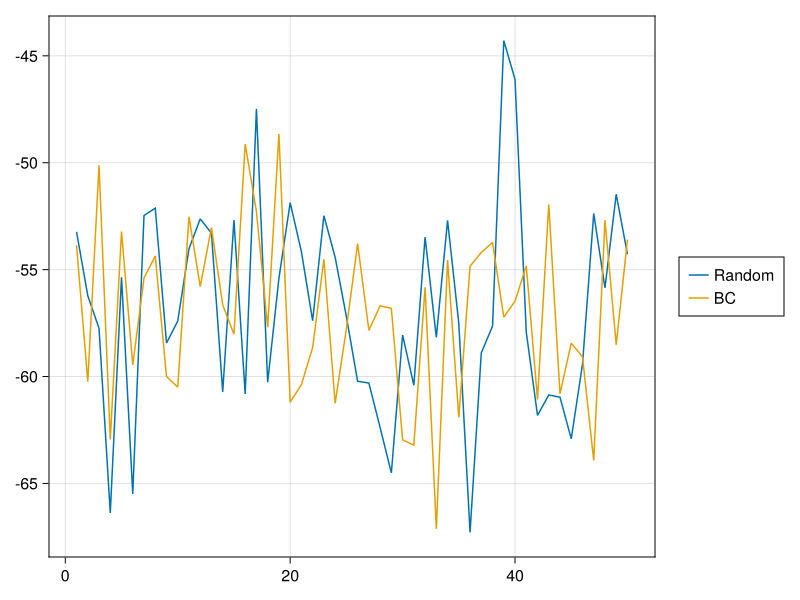

In [7]:
fig = Figure()
ax = Axis(fig[1, 1])
l = lines!(ax,1:length(score_history),score_history)
l1 = lines!(ax,1:length(score_history),bc_score_history)
Legend(fig[1, 2],
    [l, l1],
    ["Random", "BC"])
fig

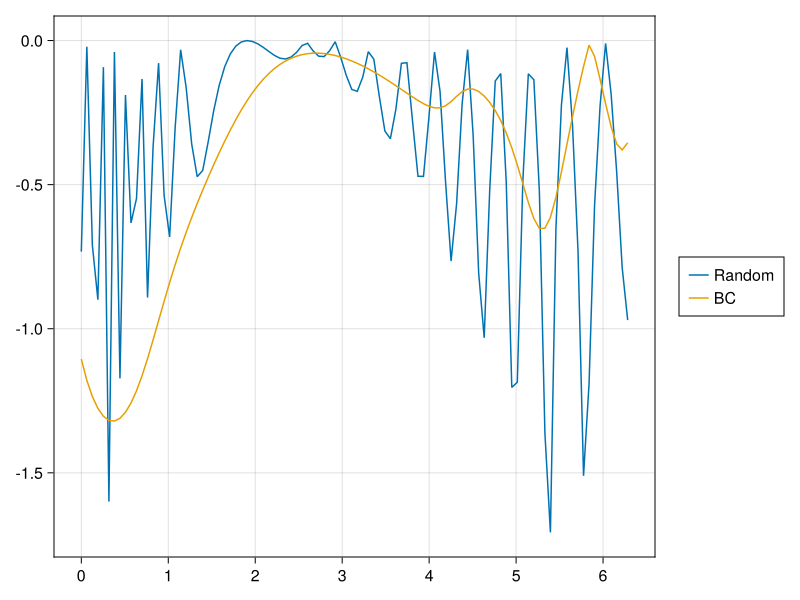

In [8]:
fig = Figure()
infid_data = policy_sample(Pretraining_Env,PPO_pretraining_𝒫,100)
infid_data1 = policy_sample(Pretraining_Env,PPO_pretraining_bc_𝒫,100)
ax = Axis(fig[1, 1])
l = lines!(ax,range(0,2π,length(infid_data)),log10.(infid_data))
l1 = lines!(ax,range(0,2π,length(infid_data1)),log10.(infid_data1))
Legend(fig[1, 2],
    [l, l1],
    ["Random", "BC"])
fig